In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skab-anomaly-detection/SKAB-master/LICENSE
/kaggle/input/skab-anomaly-detection/SKAB-master/.gitignore
/kaggle/input/skab-anomaly-detection/SKAB-master/README.md
/kaggle/input/skab-anomaly-detection/SKAB-master/utils/t2.py
/kaggle/input/skab-anomaly-detection/SKAB-master/utils/__init__.py
/kaggle/input/skab-anomaly-detection/SKAB-master/docs/contributing.md
/kaggle/input/skab-anomaly-detection/SKAB-master/docs/pictures/skab.png
/kaggle/input/skab-anomaly-detection/SKAB-master/docs/pictures/testbed.png
/kaggle/input/skab-anomaly-detection/SKAB-master/docs/pictures/nab-metric.jpg
/kaggle/input/skab-anomaly-detection/SKAB-master/notebooks/hotelling_q.ipynb
/kaggle/input/skab-anomaly-detection/SKAB-master/notebooks/mscred.ipynb
/kaggle/input/skab-anomaly-detection/SKAB-master/notebooks/isolation_forest.ipynb
/kaggle/input/skab-anomaly-detection/SKAB-master/notebooks/VAE.ipynb
/kaggle/input/skab-anomaly-detection/SKAB-master/notebooks/LSTM-AE.ipynb
/kaggle/input/skab-anomaly-d

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, mean_squared_error 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 

# Introductory Summary

1.  Dataset : SkoltechAnomaly Benchmark (SKAB)
1.  Model : 1D Convolutional Autoencoder
1.  Activation Function : ReLU
1.  Framework : Keras

* ###  Data Summary

In [3]:
#Paths of data files
all_files =[]
for root, dirs, files in os.walk('/kaggle/input/skab-anomaly-detection/SKAB-master/data/'):
    for file in files:
        if file.endswith('.csv'):
            all_files.append(os.path.join(root,file))

#Data with outliers included         
list_of_df = [pd.read_csv(file,
                            sep = ';',
                            index_col = 'datetime',
                            ) for file in all_files if 'anomaly-free' not in file]

#Anomaly free data
anomaly_free_df = pd.read_csv([file for file in all_files if 'anomaly-free' in file][0],
                             sep = ';',
                             index_col = 'datetime')



In [4]:
print('이상치 포함된 DataFrame {}개'.format(len(list_of_df)))
for i in range(len(list_of_df)) : print(list_of_df[i].columns, list_of_df[i].shape)
print('\n이상치 없는 데이터')
print(anomaly_free_df)
print('Number of change points :',sum([len(df[df.changepoint == 1.0])for df in list_of_df]) )
print('Number of outliers :',sum([len(df[df.anomaly == 1.0])for df in list_of_df]) )

df = list_of_df[0] #첫번째 데이터 사용!

이상치 포함된 DataFrame 34개
Index(['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
       'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS',
       'anomaly', 'changepoint'],
      dtype='object') (1063, 10)
Index(['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
       'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS',
       'anomaly', 'changepoint'],
      dtype='object') (995, 10)
Index(['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
       'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS',
       'anomaly', 'changepoint'],
      dtype='object') (1129, 10)
Index(['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
       'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS',
       'anomaly', 'changepoint'],
      dtype='object') (1125, 10)
Index(['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
       'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow R

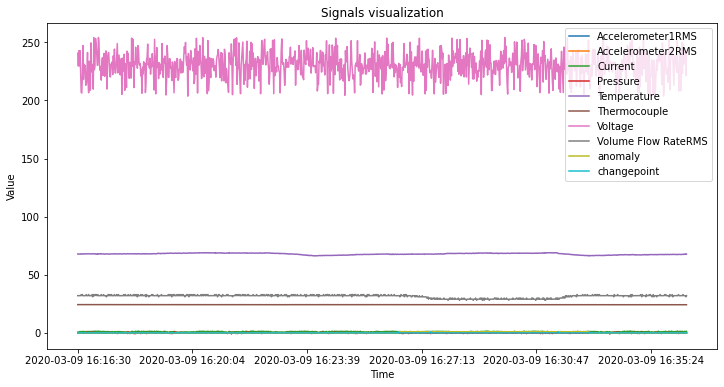

In [5]:
#시각화
df.plot(figsize = (12,6))
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Signals visualization')
plt.show()

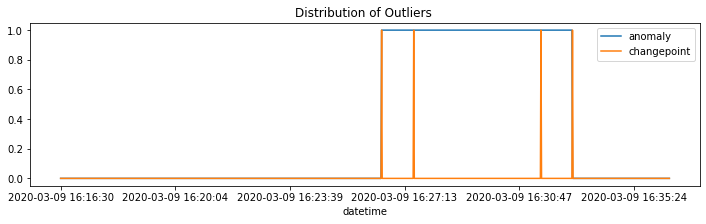

In [6]:
#이상치 분포
df.anomaly.plot(figsize = (12,3))
df.changepoint.plot()
plt.legend()
plt.title('Distribution of Outliers ')
plt.show()


* ### Model Pipeline and Preprocessing


In [7]:
# Random Seed
def Random(seed_value):
    import os
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    import random
    random.seed(seed_value)
    np.random.seed(seed_value)
    import tensorflow as tf
    tf.random.set_seed(seed_value)

In [8]:
#Convolutional AutoEncoder
def convae(data):

    model = keras.Sequential([ 
        
        layers.Input(shape = (data.shape[1], data.shape[2])),
        layers.Conv1D(filters = 32, kernel_size = 7, padding = 'same', strides = 2, activation = 'relu' ),
        layers.Conv1D(filters = 16, kernel_size = 7, padding = 'same', strides = 2, activation = 'relu' ),
        layers.Conv1DTranspose(filters = 16, kernel_size = 7, padding = 'same', strides = 2, activation = 'relu' ),
        layers.Conv1DTranspose(filters = 32, kernel_size = 7, padding = 'same', strides = 2, activation = 'relu' ),
        layers.Conv1DTranspose(filters = 8, kernel_size = 7, padding = 'same'),  # shape 일치시키기 위한 layer(오토인코더 구조) 
    
    ])

    model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001), loss = 'mse')
    
    model.summary()

    # Training
    history = model.fit(        
        data,
        data, # data X instead of Y because it's unsupervised learning
        epochs = 100,
        batch_size = 32,
        verbose = 10,

        # early stopping 자동 학습 중단. patience 5번 loss 상승시 중단
        callbacks = [
            keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 0)
        ]

    )
    return history, model

In [9]:
#Preprocessing
X_train = df[:400].drop(columns = ['anomaly','changepoint']) ##0~400번까지 모두 정상데이터이므로 학습데이터로 선정

StSc = StandardScaler()
X_train_scale = StSc.fit(X_train)  ## Standardization(표준) : train data의 평균, 분산분포를 저장. 추후에 test data에도 똑같이 적용필요
X_train_scale = StSc.transform(X_train)

X_train

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
datetime,,,,,,,,
2020-03-09 16:16:30,0.027545,0.041127,0.673506,0.054711,67.8345,24.3164,240.513,32.0000
2020-03-09 16:16:31,0.027997,0.039100,0.772264,0.054711,67.8704,24.3279,229.523,32.0000
2020-03-09 16:16:32,0.028418,0.038872,0.675520,0.054711,67.7882,24.3261,242.708,32.0000
2020-03-09 16:16:33,0.027625,0.039366,0.566279,-0.273216,67.7918,24.3323,229.709,32.0000
2020-03-09 16:16:34,0.027484,0.041854,1.292170,0.054711,67.7368,24.3250,242.746,32.0000
...,...,...,...,...,...,...,...,...
2020-03-09 16:23:34,0.027472,0.040456,1.492290,-0.273216,67.1832,24.2753,243.226,32.0394
2020-03-09 16:23:35,0.027264,0.040137,1.351580,0.382638,67.0627,24.2697,234.532,32.9617
2020-03-09 16:23:36,0.027883,0.040341,1.227560,0.054711,66.8029,24.2754,231.807,31.9618


In [10]:
# sequence를 고려한 전처리
# 데이터를 임의의 sequence 묶음
def create_sequences(data, time_steps = 60):
    out = []
    for i in range(len(data) - time_steps + 1):
        out.append(data[i : (i + time_steps)])
    return np.stack(out)

X_train_seq = create_sequences(X_train,60) #400의 정상데이터를 60개의 묶음으로 1씩 shift 하며 묶음 -> 341개 생성
X_train_seq.shape 

(341, 60, 8)

In [11]:
history, model = convae(X_train_seq)

2023-02-07 11:59:24.056102: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 30, 32)            1824      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 15, 16)            3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 30, 16)            1808      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 60, 32)            3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 60, 8)             1800      
Total params: 12,648
Trainable params: 12,648
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2023-02-07 11:59:24.330462: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78/100
Epoch 7

* ### Anomaly Score